<a href="https://colab.research.google.com/github/ishaaaa12/BERT-Text-Classification-for-Sentiment-Analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from transformers.optimization import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [96]:
# Set random seed for reproducibility
import random
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [97]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [98]:
df = pd.read_csv('smile-annotations-final.csv', names=['id', 'text', 'category'])
df.set_index('id', inplace=True)

In [99]:
df.head()

,text,category
id,,
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
614877582664835073,@Sofabsports thank you for following me back. ...,happy
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


In [100]:
df.category.value_counts()

,count
category,
nocode,1572
happy,1137
not-relevant,214
angry,57
surprise,35
sad,32
happy|surprise,11
happy|sad,9
disgust|angry,7


In [101]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    return text.strip()


In [102]:
df['text'] = df['text'].apply(clean_text)

In [103]:
df = df[~df.category.str.contains('\|')]

In [104]:
df = df[df.category != 'nocode']

In [105]:
df.category.value_counts()

,count
category,
happy,1137
not-relevant,214
angry,57
surprise,35
sad,32
disgust,6


In [106]:
import nlpaug.augmenter.word as naw
def augment_text(texts, aug, n_aug=5):
    """Augment a list of texts n_aug times using the provided augmenter."""
    augmented_texts = []
    for text in texts:
        # Generate n_aug augmented versions of each text
        aug_texts = aug.augment(text, n=n_aug)
        augmented_texts.extend(aug_texts)
    return augmented_texts

# Initialize synonym augmenter (using WordNet)
aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.3)

# Define target sample sizes for minority classes
target_samples = {
    'disgust': 50,   # Increase from 6 to ~50
    'sad': 100,      # Increase from 32 to ~100
    'surprise': 100  # Increase from 35 to ~100
}

# Perform augmentation for minority classes
augmented_data = []
for category in target_samples:
    # Get texts for the current category
    category_texts = df[df.category == category]['text'].values
    current_count = len(category_texts)
    target_count = target_samples[category]

    if current_count < target_count:
        # Calculate how many augmented samples are needed
        samples_needed = target_count - current_count
        # Number of augmentations per text
        n_aug = max(1, samples_needed // current_count + 1)
        # Generate augmented texts
        aug_texts = augment_text(category_texts, aug, n_aug=n_aug)
        # Trim to exact number needed
        aug_texts = aug_texts[:samples_needed]
        # Create DataFrame for augmented data
        aug_df = pd.DataFrame({
            'text': aug_texts,
            'category': category,
            'id': [f'aug_{category}_{i}' for i in range(len(aug_texts))]
        })
        augmented_data.append(aug_df)

# Combine original and augmented data
if augmented_data:
    augmented_df = pd.concat(augmented_data, ignore_index=True)
    df = pd.concat([df.reset_index(), augmented_df], ignore_index=True)
    df.set_index('id', inplace=True)

# Verify new class distribution
print("New class distribution after augmentation:")
print(df.category.value_counts())

New class distribution after augmentation:
category
happy           1137
not-relevant     214
surprise         100
sad              100
angry             57
disgust           50
Name: count, dtype: int64


In [107]:
# Create label dictionary
possible_labels = df.category.unique()
label_dict = {label: idx for idx, label in enumerate(possible_labels)}
df['label'] = df.category.replace(label_dict)

<ipython-input-107-3301421638>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df.category.replace(label_dict)


In [108]:
df.head()

,text,category,label
id,,,
614484565059596288,Dorian Gray with Rainbow Scarf LoveWins from b...,happy,0
614746522043973632,SelectShowcase TateStIves Replace with your w...,happy,0
614877582664835073,Sofabsports thank you for following me back Gr...,happy,0
611932373039644672,britishmuseum TudorHistory What a beautiful je...,happy,0
611570404268883969,NationalGallery ThePoldarkian I have always lo...,happy,0


In [109]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.2,  # Increased validation size
    random_state=17,
    stratify=df.label.values
)

In [110]:
df['data_type'] = ['not_set']*df.shape[0]

In [111]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [112]:
# Print class distribution
df.groupby(['category', 'label', 'data_type']).count()

text
category     label data_type      
angry        2     train        46
                   val          11
disgust      3     train        40
                   val          10
happy        0     train       909
                   val         228
not-relevant 1     train       171
                   val          43
sad          4     train        80
                   val          20
surprise     5     train        80
                   val          20

In [113]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

In [114]:
# Check text length distribution to optimize max_length
text_lengths = df.text.apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))
print(text_lengths.describe())

count    1658.000000
mean       22.213510
std         7.280417
min         5.000000
25%        17.000000
50%        22.500000
75%        27.000000
max        44.000000
Name: text, dtype: float64


In [115]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type == 'train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    max_length=128,  # Adjusted based on typical text length
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type == 'val'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='pt'
)


In [116]:
# Prepare datasets
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)


In [117]:
len(dataset_train)

1326

In [118]:

len(dataset_val)

332

In [119]:
# DataLoaders
batch_size = 16  # Reduced for more gradient updates
dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)


In [120]:
# Initialize model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_dict),
    output_attentions=False,
    output_hidden_states=False
)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [121]:
# Compute class weights for imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(df.label.values), y=df.label.values)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


In [122]:
# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 10  # Increased epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

In [123]:
# Evaluation functions
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='macro')  # Use macro F1

In [124]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        # Use average=None to get per-class metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_preds, average=None, labels=[label], zero_division=0
        )
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds == label])}/{len(y_true)}')
        print(f'Precision: {precision[0]:.3f}, Recall: {recall[0]:.3f}, F1: {f1[0]:.3f}\n')

In [125]:
def plot_confusion_matrix(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    cm = confusion_matrix(labels_flat, preds_flat)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [126]:
def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        with torch.no_grad():
            outputs = model(**inputs)
        loss = criterion(outputs[1], inputs['labels'])
        loss_val_total += loss.item()
        logits = outputs[1].detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_val)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    return loss_val_avg, predictions, true_vals

In [131]:
# Training loop with early stopping
best_val_f1 = 0
patience = 3
epochs_no_improve = 0

for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, desc=f'Epoch {epoch}', leave=False, disable=False)

    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        outputs = model(**inputs)
        loss = criterion(outputs[1], inputs['labels'])
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': f'{loss.item()/len(batch):.3f}'})

    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write(f'\nEpoch {epoch}')
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Macro F1 Score: {val_f1}')

    # Save best model based on validation F1
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_model.model')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/83 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.027869277712271875
Validation loss: 0.7993706292251036
Macro F1 Score: 0.8103160459648192


Epoch 2:   0%|          | 0/83 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.03159728683306869
Validation loss: 0.7993706292251036
Macro F1 Score: 0.8103160459648192


Epoch 3:   0%|          | 0/83 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.026553547413772846
Validation loss: 0.7993706292251036
Macro F1 Score: 0.8103160459648192


Epoch 4:   0%|          | 0/83 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.027909304733466672
Validation loss: 0.7993706292251036
Macro F1 Score: 0.8103160459648192
Early stopping triggered


Class: happy
Accuracy: 204/228
Precision: 1.000, Recall: 0.895, F1: 0.944

Class: not-relevant
Accuracy: 28/43
Precision: 1.000, Recall: 0.651, F1: 0.789

Class: angry
Accuracy: 9/11
Precision: 1.000, Recall: 0.818, F1: 0.900

Class: disgust
Accuracy: 10/10
Precision: 1.000, Recall: 1.000, F1: 1.000

Class: sad
Accuracy: 18/20
Precision: 1.000, Recall: 0.900, F1: 0.947

Class: surprise
Accuracy: 19/20
Precision: 1.000, Recall: 0.950, F1: 0.974



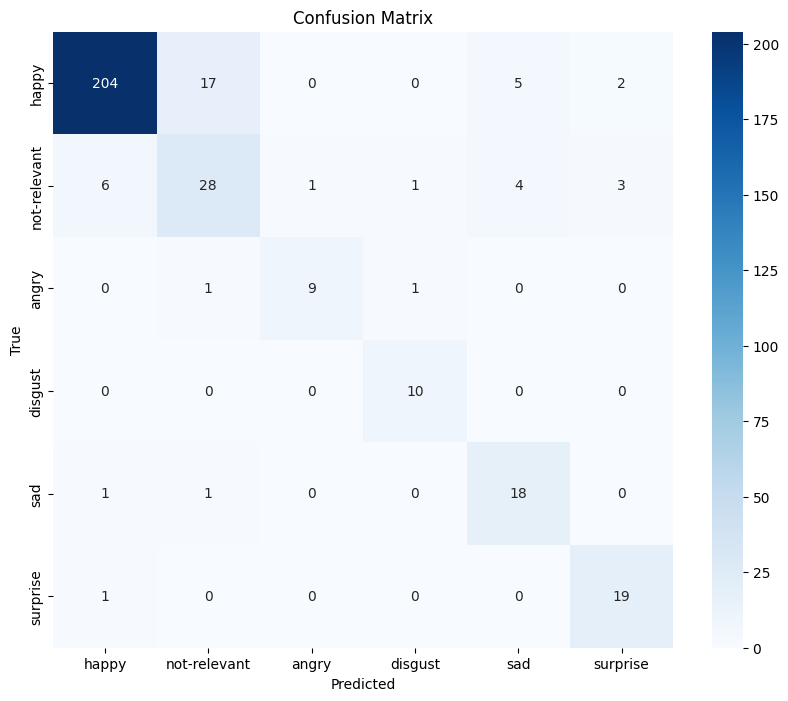

In [128]:
# Load and evaluate the best model
model.load_state_dict(torch.load('best_model.model', map_location=device))
val_loss, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)
plot_confusion_matrix(predictions, true_vals)